# CIFAR10

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,  .5, .5),(.5,  .5, .5))])
ds_train = torchvision.datasets.CIFAR10('../../data/', train=True, transform=tfms, download=True)
ds_test = torchvision.datasets.CIFAR10('../../data/', train=False, transform=tfms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=4, shuffle=False)

In [5]:
dl_train

## Visualize

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def show_img(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg.transpose(1,2,0))
    plt.show()

In [8]:
dataiter = iter(dl_train)
images, labels = dataiter.next()

In [9]:
images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

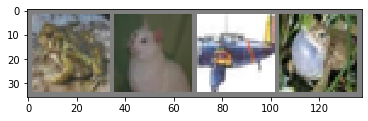

In [10]:
show_img(torchvision.utils.make_grid(images))

In [11]:
print([classes[x] for x in labels])

['frog', 'cat', 'plane', 'frog']


In [12]:
class CIFARNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=1, padding=0)
        self.m = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1, padding=0)
        self.l1 = nn.Linear(in_features=16*5*5, out_features=128)
        self.l2 = nn.Linear(in_features=128, out_features=64)
        self.l3 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        x = F.relu(self.m(self.c1(x)))
        x = F.relu(self.m(self.c2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))        
        x = self.l3(x)
        return x

In [13]:
model = CIFARNet()

## Loss

In [14]:
import torch.optim as optim

In [15]:
epochs = 2

In [16]:
len(dl_train), len(dl_train)/4

(12500, 3125.0)

In [17]:
device = torch.device('cuda:0')
# device = torch.device('cpu')

model.train()
model.to(device)


CIFARNet(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (m): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (l1): Linear(in_features=400, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(dl_train, start=1):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%2000 == 0:
            print(f"[{epoch} / {i}] - loss: {running_loss/2000}")
            running_loss = 0

[0 / 2000] - loss: 2.2217955102920532
[0 / 4000] - loss: 1.8653915226757527
[0 / 6000] - loss: 1.65580162486434
[0 / 8000] - loss: 1.567489693135023
[0 / 10000] - loss: 1.4988190212100745
[0 / 12000] - loss: 1.4937761561721563
[1 / 2000] - loss: 1.4097282679826022
[1 / 4000] - loss: 1.3836565953493118
[1 / 6000] - loss: 1.3742681024372578
[1 / 8000] - loss: 1.3262441865354777
[1 / 10000] - loss: 1.3192281851023435
[1 / 12000] - loss: 1.2831508386284114


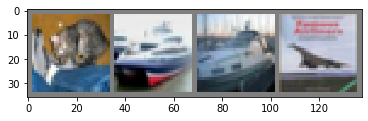

Truth :['cat', 'ship', 'ship', 'plane']
Preds :['cat', 'car', 'car', 'plane']


In [49]:
model.eval()

images, labels = iter(dl_test).next()
with torch.no_grad():
    pred = model(images.to(device))

show_img(torchvision.utils.make_grid(images))
print(f"Truth :{[classes[x] for x in labels]}")
print(f"Preds :{[classes[x] for x in torch.argmax(pred, axis=1)]}")